In [1]:
from keras import backend as K
from keras import layers
from keras import models
from keras.datasets import mnist
import numpy as np
from keras import losses

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshape and normalize the input images
x_train = x_train.reshape(-1, 784).astype('float32') / 255
x_test = x_test.reshape(-1, 784).astype('float32') / 255

# Size of the latent space
latent_dim = 2

# Encoder
inputs = layers.Input(shape=(784,))
x = layers.Dense(64, activation='relu')(inputs)
x = layers.Dense(64, activation='relu')(x)
mu = layers.Dense(latent_dim)(x)
sigma = layers.Dense(latent_dim)(x)

# Reparametrization trick
def sample_z(args):
    mu, sigma = args
    eps = K.random_normal(shape=(K.shape(mu)[0], latent_dim), mean=0, stddev=1)
    return mu + K.exp(sigma / 2) * eps

z = layers.Lambda(sample_z)([mu, sigma])

# Decoder
decoder_inputs = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(64, activation='relu')(decoder_inputs)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(784, activation='sigmoid')(x)

# Instantiate the encoder and decoder
encoder = models.Model(inputs, [mu, sigma, z], name='encoder')
decoder = models.Model(decoder_inputs, outputs, name='decoder')

# VAE
outputs = decoder(encoder(inputs)[2])
vae = models.Model(inputs, outputs, name='vae')

# Loss function
reconstruction_loss = 784 * losses.binary_crossentropy(inputs, outputs)
kl_loss = - 0.5 * K.sum(1 + sigma - K.square(mu) - K.exp(sigma), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)

# Compile and train the VAE
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.fit(x_train, epochs=10, batch_size=32, validation_data=(x_test, None))



Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 187.0886 - val_loss: 169.8231
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 166.3085 - val_loss: 163.3803
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 160.8631 - val_loss: 159.1751
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 157.0715 - val_loss: 155.9807
Epoch 5/10
1875/1875 [==============================] - 5s 2ms/step - loss: 154.8548 - val_loss: 154.2024
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 153.2415 - val_loss: 153.4140
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 152.0511 - val_loss: 151.4739
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 151.0233 - val_loss: 150.7787
Epoch 9/10
1875/1875 [==============================] - 5s 2ms/step - loss: 150.1600 - val_loss: 149.7954
Epoch 10/10
1875/1875 [=======================

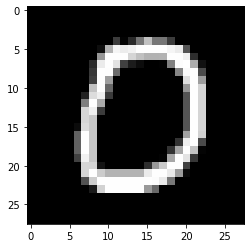

1/1 [==============================] - 0s 129ms/step


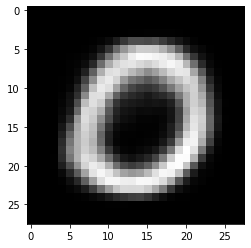

In [2]:
import matplotlib.pyplot as plt
#original image
output_img_orig = x_test[10]
output_img_orig = output_img_orig.reshape(28, 28)
output_img_orig = output_img_orig * 255
plt.imshow(output_img_orig, cmap='gray')
plt.show()

#Image from VAE
output_img = vae.predict(x_test[10].reshape(1, -1))
output_img = output_img.reshape(28, 28)
output_img = output_img * 255
plt.imshow(output_img, cmap='gray')
plt.show()

In [3]:
z_mean, _, _ = encoder.predict(x_test)

313/313 [==============================] - 0s 1ms/step


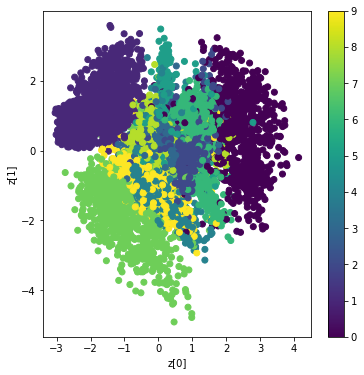

In [4]:
import matplotlib.pyplot as plt
#visualizing the latent space
plt.figure(figsize=(6, 6))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()


# just checking for github